In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

plt.style.use('default')

## EDA

In [ ]:
# load data -store1.csv
store1 = pd.read_csv("../store1.csv")

In [ ]:
store1.head()

In [ ]:
# get the max and min date for every family
store1.groupby('family').agg({'date':['min','max', 'count'], 'sales':'sum'})


In [ ]:
from datetime import date

start = date(2013, 1, 1)
end = date(2017, 8, 15)
delta = end - start
print(delta.days)

In [ ]:
#plot whole sales for few family 
for family in store1['family'].unique()[2:6]:
    family = store1['family'].unique()[2]
    store1[store1['family']==family].plot(x='date',y='sales',title=family,linewidth=0.5)
    plt.xticks(rotation=90)
    plt.show()

## Podział na zbiór treningowy i testowy

In [ ]:
# train test split - test from ('2017-08-07') (last whole week)
split_date = '2017-08-07'
train = store1.loc[store1['date'] < split_date].copy()
# test date from 2017-08-07 to 2017-08-14
test = store1.loc[(store1['date'] >= split_date) & (store1['date'] < "2017-08-14")].copy()

train['date'] = pd.to_datetime(train['date'])  # Convert 'date' column to datetime format
test['date'] = pd.to_datetime(test['date'])  # Convert 'date' column to datetime format

print("Pierwsza data zbioru treningowego: ", train['date'].min(), train['date'].min().strftime('%A'))
print("Ostatnia data zbioru treningowego: ",train['date'].max(), train['date'].max().strftime('%A'))
print("Pierwsza data zbioru testowego: ", test['date'].min(), test['date'].min().strftime('%A'))
print("Ostatnia data zbioru treningowego: ", test['date'].max(), test['date'].max().strftime('%A'))


## MODELE LOKALNE

In [ ]:
from darts import TimeSeries
from darts.models import NaiveSeasonal
from darts.metrics import mse

In [ ]:
# create time series for every family
y_sku = TimeSeries.from_group_dataframe(train,
                                        group_cols='family',
                                        time_col='date',
                                        value_cols='sales',
                                        fill_missing_dates=True,
                                        freq='D',
                                        fillna_value=0)

In [ ]:
backtest_start_date = pd.Timestamp('2017-07-10')

### Naiwny - powtarzamy ostatnią sprzedaż

In [ ]:
backtest_naive = {
    y_sku[number].static_covariates['family'].values[0]: 
    NaiveSeasonal().backtest(series = time_series, start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)
    for (number, time_series) in enumerate(y_sku)}

In [ ]:
rmse_backtest_naive = np.sqrt(sum(backtest_naive.values()))
print(f"RMSE for Naive forecast: {rmse_backtest_naive}")

### Naiwny -  powtarzamy średnią z ostatnich 7 dni

In [ ]:
from darts.models import NaiveMean

In [ ]:
backtest_naivemean = {
    y_sku[number].static_covariates['family'].values[0]: 
    NaiveMean().backtest(series = time_series, train_length=7, start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)
    for (number, time_series) in enumerate(y_sku)}

In [ ]:
rmse_backtest_naivemean = np.sqrt(sum(backtest_naivemean.values()))
print(f"RMSE for Naive forecast: {rmse_backtest_naivemean}")

In [ ]:
historical_naivemean = {
    y_sku[number].static_covariates['family'].values[0]: 
    NaiveMean().historical_forecasts(series = time_series, train_length=7, start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True)
    for (number, time_series) in enumerate(y_sku)}

## MODELE GLOBALNE

In [ ]:
from darts.models import LightGBMModel

In [ ]:
# future covariates - onpromotion
future_cov_all = TimeSeries.from_group_dataframe(store1, # uzywamy stro1, bo mamy tam wszystkie wartosci onpromotion
                                                 group_cols='family',
                                                 time_col='date',
                                                 value_cols='onpromotion',
                                                 fill_missing_dates=True,
                                                 freq='D',
                                                 fillna_value=0)

In [ ]:
from darts.dataprocessing.transformers import StaticCovariatesTransformer

transformer = StaticCovariatesTransformer()
y_sku_t = transformer.fit_transform(y_sku)

### LightGBMModel

In [ ]:
lgbm_model = LightGBMModel(
    lags=7,
    # lags_past_covariates=0,
    lags_future_covariates=[0],
    add_encoders={
        "cyclic": {"future": ["dayofweek", "month", "weekofyear", "quarter"]}
    },
    output_chunk_length=1, # jezeli używamy lagi to bedziemy konsumowac własne prognozy jezeli forecast_horizon > output_chunk_length
    verbose=-1
)


In [ ]:
backtest_lgbm = lgbm_model.backtest(series = y_sku_t, future_covariates=future_cov_all,  start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)

In [ ]:
rmse_backtest_lgbm = np.sqrt(sum(backtest_lgbm))
print(f"RMSE for LGBM forecast: {rmse_backtest_lgbm}")

### Random Forest

In [ ]:
# Random Forest
from darts.models import RandomForest
rf_model = RandomForest(
    lags=7,
    lags_future_covariates=[0],
    add_encoders={
        "cyclic": {"future": ["dayofweek", "month", "weekofyear", "quarter"]}
    },
    output_chunk_length=1,
    n_estimators=10
    # criterion="absolute_error",
)

In [ ]:
backtest_rf = rf_model.backtest(series = y_sku_t, future_covariates=future_cov_all,  start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)

In [ ]:
rmse_backtest_rf = np.sqrt(sum(backtest_rf))
print(f"RMSE for RandomForest forecast: {rmse_backtest_rf}")

### XGBoost

In [ ]:
from darts.models import XGBModel
xgb_model = XGBModel(
    lags=7,
    lags_future_covariates=[0],
    add_encoders={
        "cyclic": {"future": ["dayofweek", "month", "weekofyear", "quarter"]}
    },
    output_chunk_length=1,
)
backtest_xgb = xgb_model.backtest(series = y_sku_t, future_covariates=future_cov_all,  start=backtest_start_date, forecast_horizon=7, stride=7, verbose=True, metric = mse)

In [ ]:
rmse_backtest_xgb = np.sqrt(sum(backtest_xgb))
print(f"RMSE for RandomForest forecast: {rmse_backtest_xgb}")

## Porównanie wyników modeli

In [ ]:
print(f"RMSE for Naivemean forecast: {rmse_backtest_naivemean}")
print(f"RMSE for Naive forecast: {rmse_backtest_naive}")
print(f"RMSE for RandomForest forecast: {rmse_backtest_xgb}")
print(f"RMSE for RandomForest forecast: {rmse_backtest_rf}")
print(f"RMSE for LGBM forecast: {rmse_backtest_lgbm}")

df = pd.DataFrame({'Naive': rmse_backtest_naive, 'NaiveMean': rmse_backtest_naivemean, 'RandomForest': rmse_backtest_rf, 'XGB': rmse_backtest_xgb, 'LGBM': rmse_backtest_lgbm}, index=[0])
ax = df.T.plot(kind='bar')  # Transpose DataFrame before plotting
ax.set_xlabel("Models")
ax.set_ylabel("RMSE")
plt.show()

## Prognozy testowe

In [ ]:
# create predictions for test set
rf_model.fit( y_sku_t, future_covariates=future_cov_all)


In [ ]:
rf_forecast = rf_model.predict(n=7, series=y_sku_t, future_covariates=future_cov_all)


In [ ]:
forecastT = transformer.inverse_transform(rf_forecast)

In [ ]:
df_forecast = pd.DataFrame()
for (number, time_series) in enumerate(forecastT):
    family_forecast = time_series.pd_dataframe().reset_index()
    family_forecast['family'] = time_series.static_covariates['family'].values[0]
    df_forecast = pd.concat([df_forecast, family_forecast])
    
    

In [ ]:
df_forecast

In [ ]:
# plot forecast for every family with test set
for family in df_forecast['family'].unique():
    family_train = train[(train['family']==family) & (train['date'] > pd.to_datetime('2017-06-01'))]    
    plt.plot(family_train['date'], family_train['sales'], label="Train")

    plt.plot(df_forecast[df_forecast['family']==family]['date'], df_forecast[df_forecast['family']==family]['sales'], label="Forecast")
    plt.plot(test[test['family']==family]['date'], test[test['family']==family]['sales'], label="Actual", linestyle='dashed')
    plt.title(family)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [ ]:

df_forecast = df_forecast.merge(test[['date', 'family', 'sales']], on=['date', 'family'], how='left', suffixes=('', '_test'))
df_forecast.columns = ['date', 'forecast_sale', 'family', 'sales']

In [ ]:
df_forecast.columns 

In [ ]:
from sklearn.metrics import mean_squared_error

# calculate RMSE for every family
rmse = {} 
for family in df_forecast['family'].unique():
    rmse[family] = mean_squared_error(df_forecast[df_forecast['family']==family]['sales'], df_forecast[df_forecast['family']==family]['forecast_sale'], squared=False)


In [ ]:
df_rmse = pd.DataFrame(rmse.items(), columns=['family', 'rmse'])

df_forecast_grouped = df_forecast.groupby('family').agg({'sales':'sum', 'forecast_sale':'sum'}).reset_index().rename(columns={'sales':'mean_sales', 'forecast_sale':'mean_forecast_sales'})
df_rmse = df_rmse.merge(df_forecast_grouped, on='family', how='left')

### RMSE dla każdej rodziny produktowej

In [ ]:
df_rmse['forecast/sales'] = df_rmse['mean_forecast_sales'] / df_rmse['mean_sales']
df_rmse.sort_values(by='forecast/sales', ascending=False)


In [228]:
store1

,Unnamed: 0,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
55567,55567,2017-08-15,1,POULTRY,234.892000,0
55568,55568,2017-08-15,1,PREPARED FOODS,42.822998,0
55569,55569,2017-08-15,1,PRODUCE,2240.230000,7
55570,55570,2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0.000000,0


In [234]:
family = store1['family'].unique()[2]


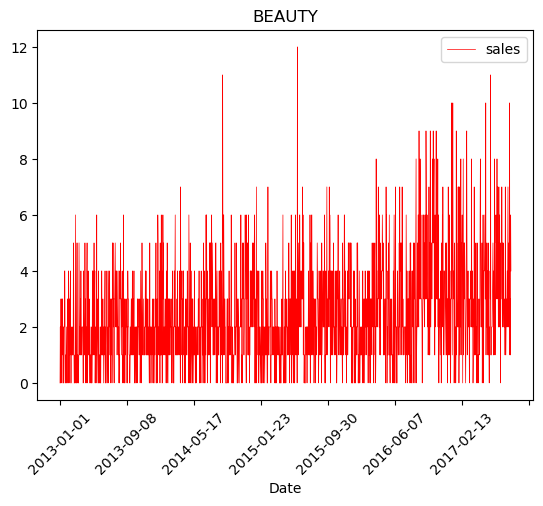

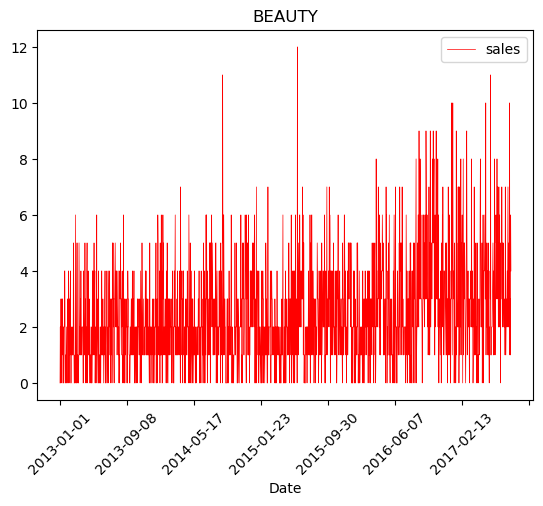

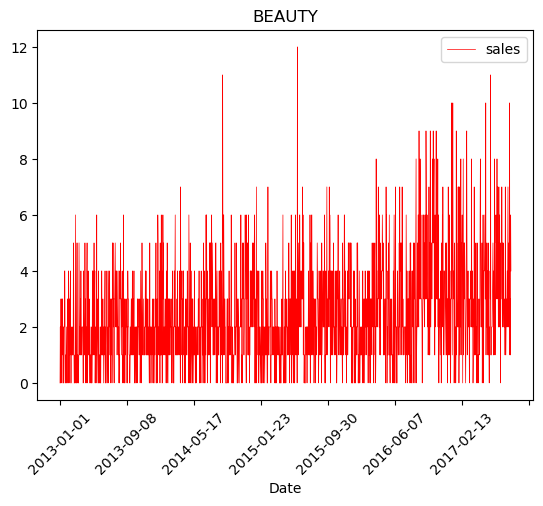

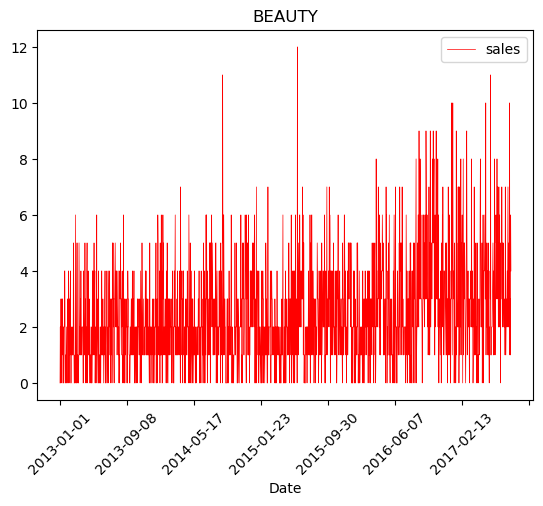

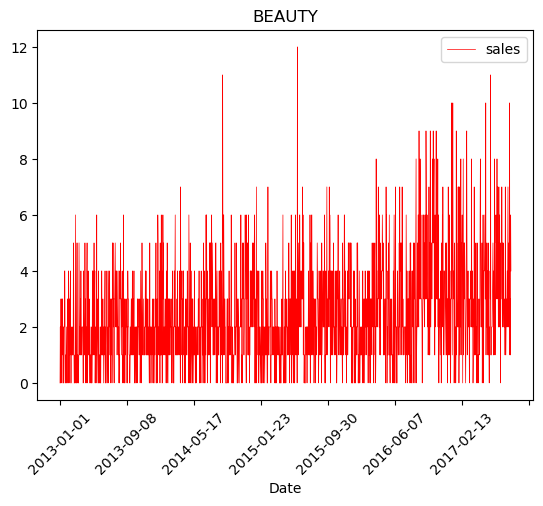

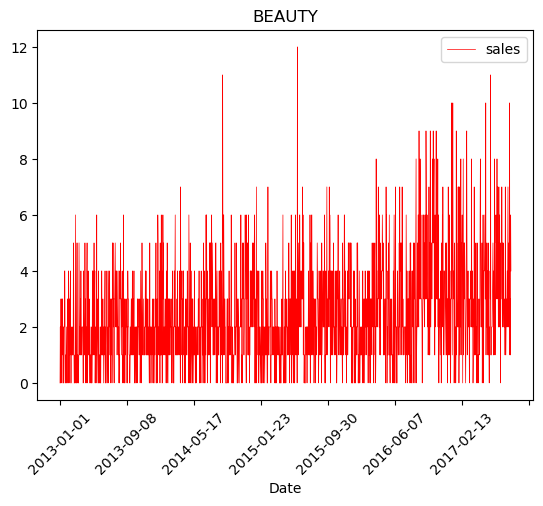

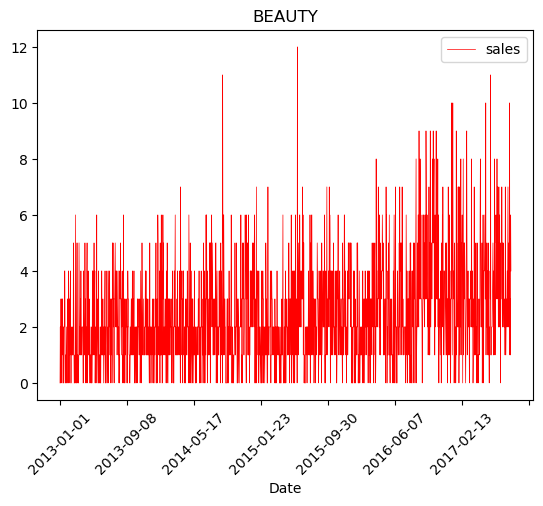

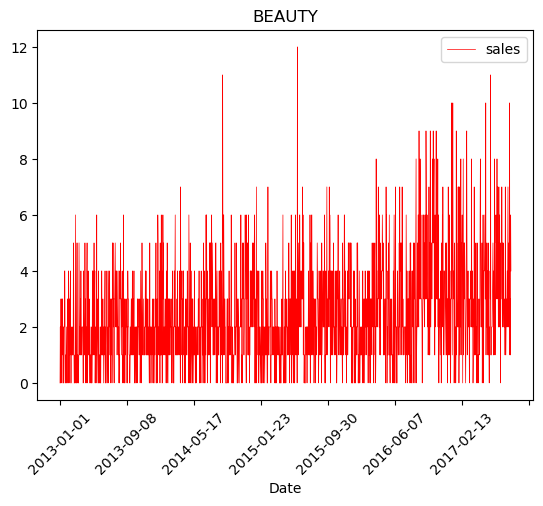

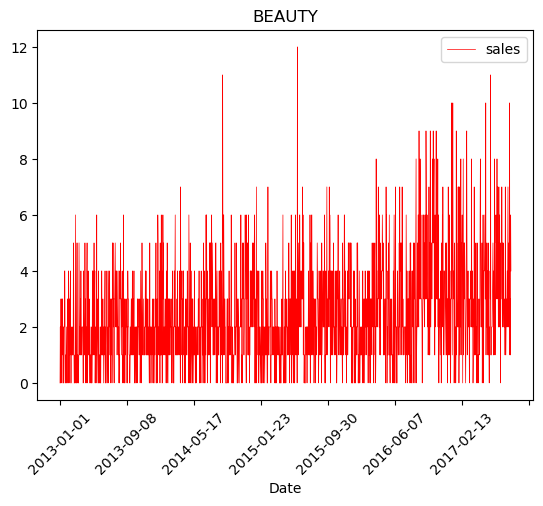

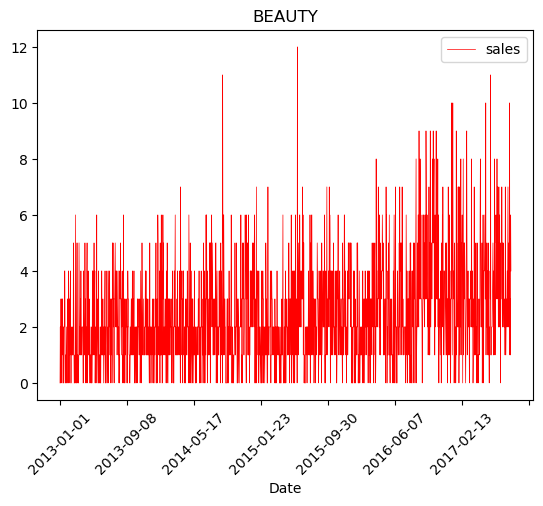

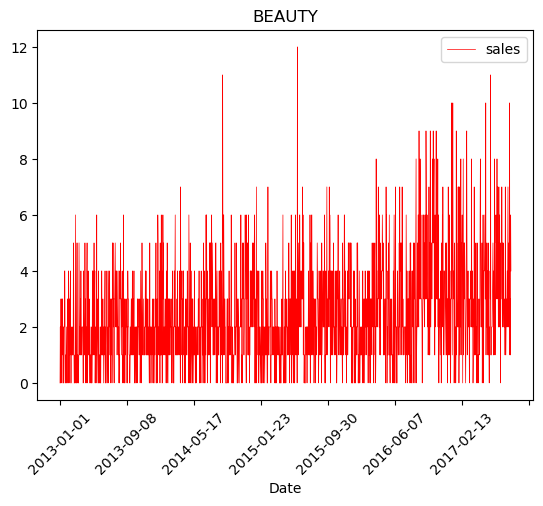

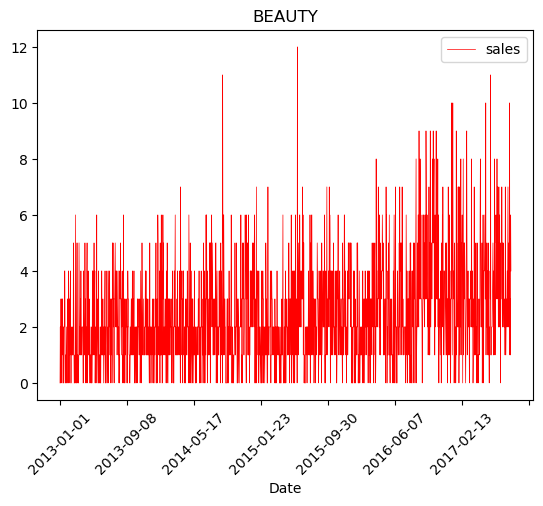

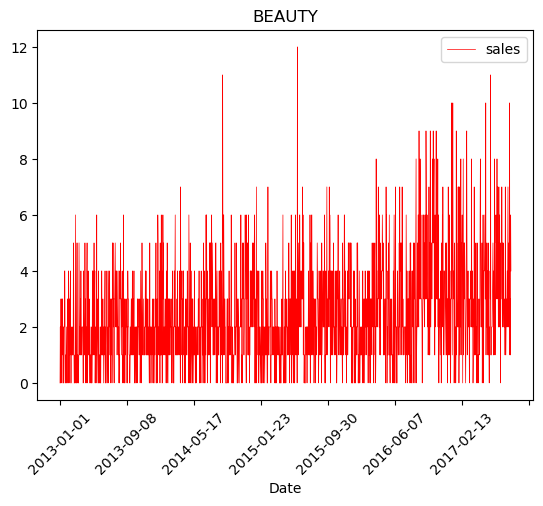

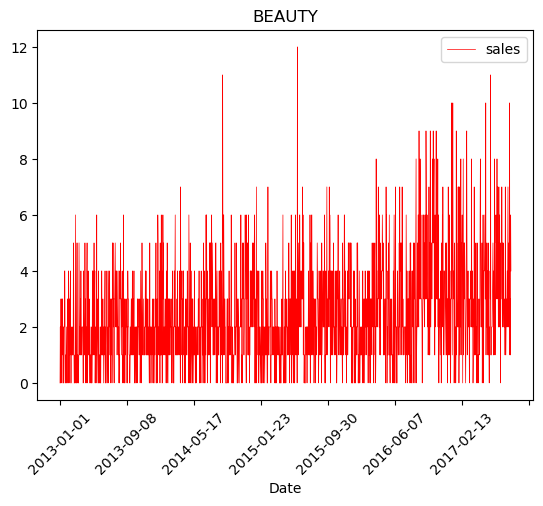

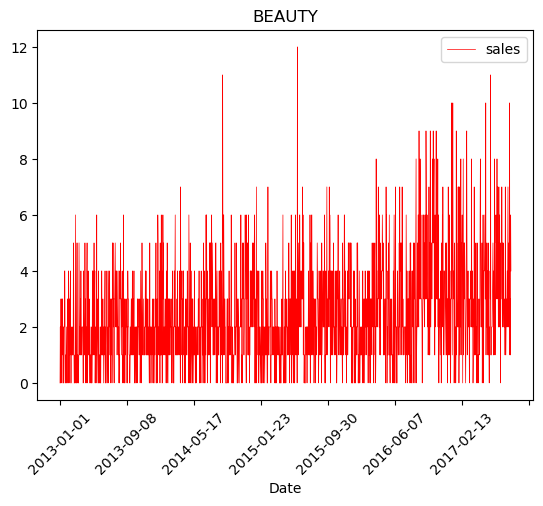

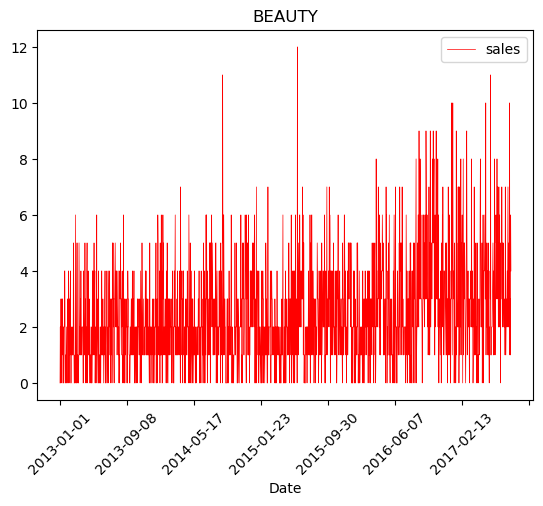

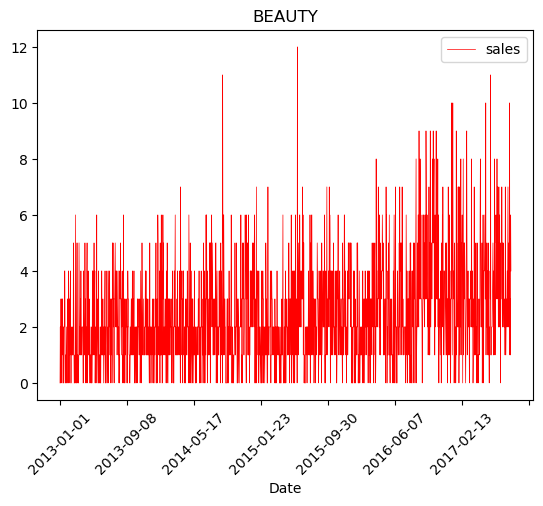

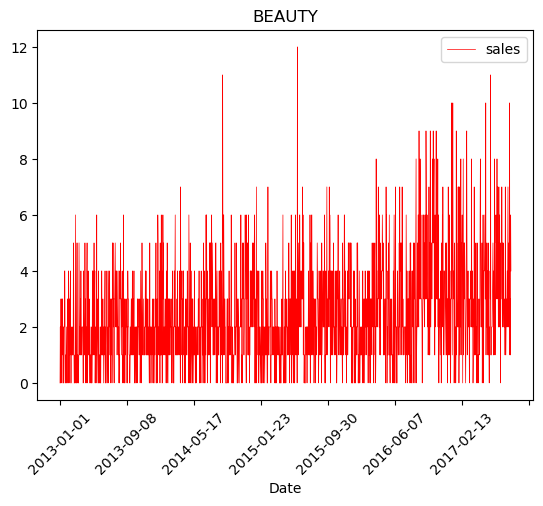

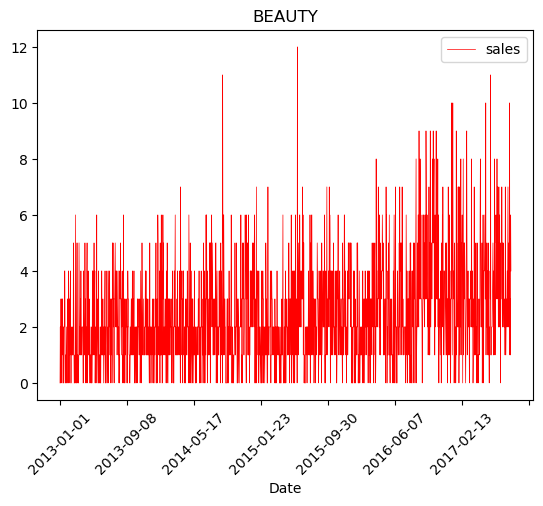

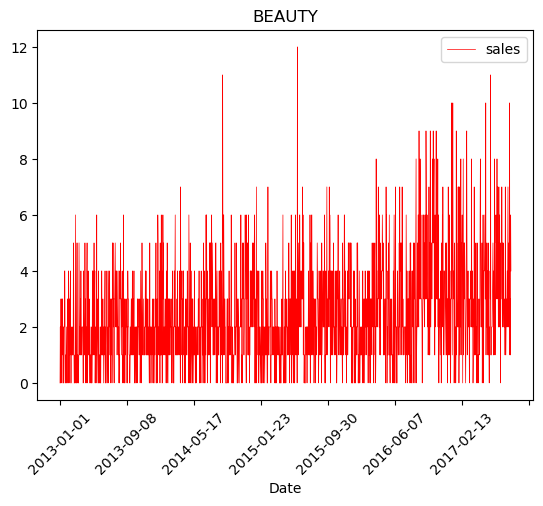

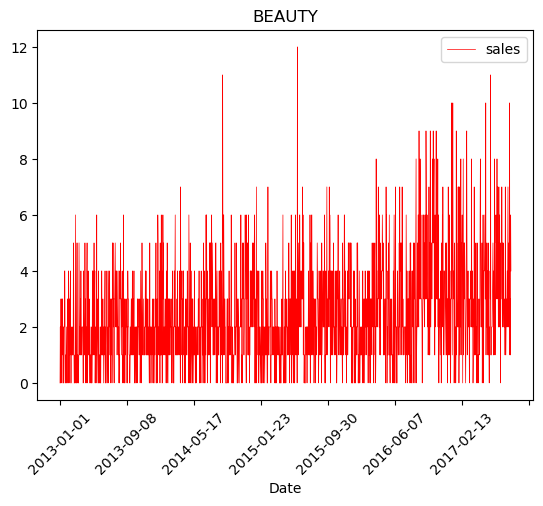

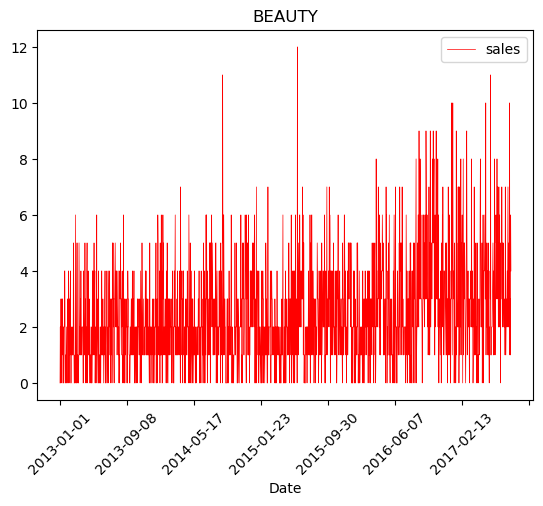

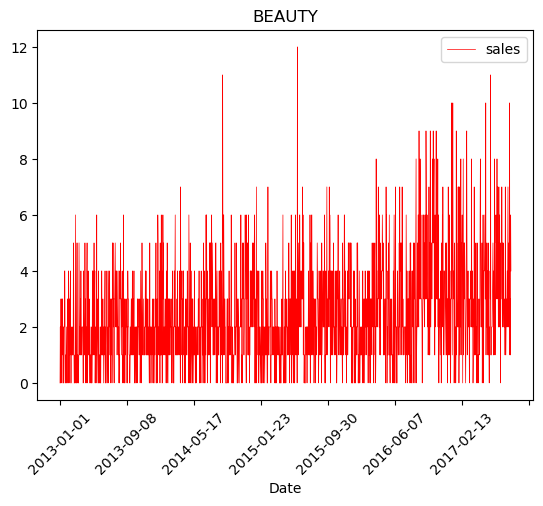

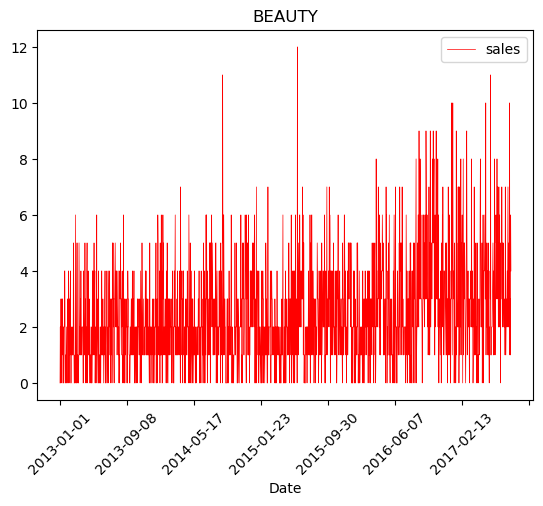

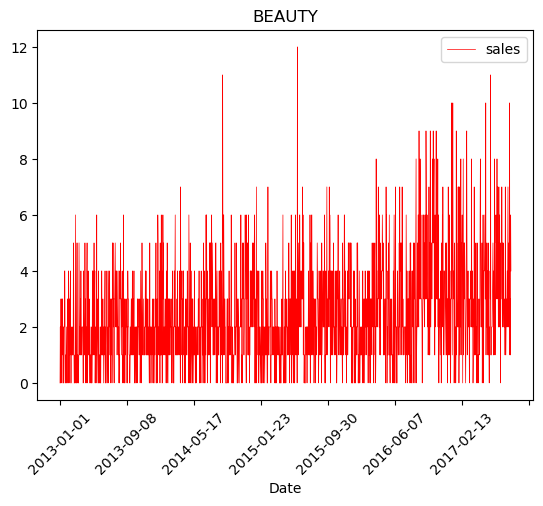

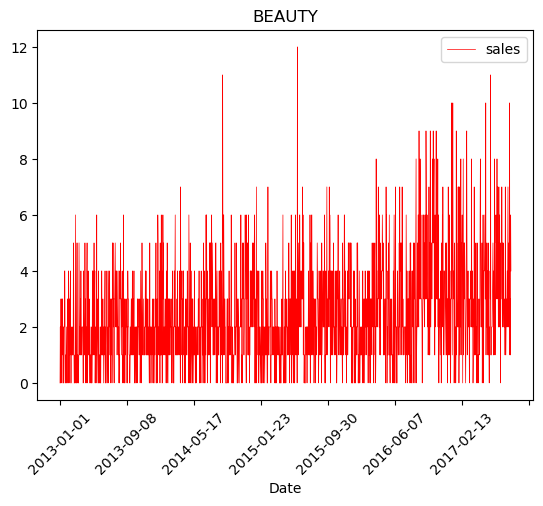

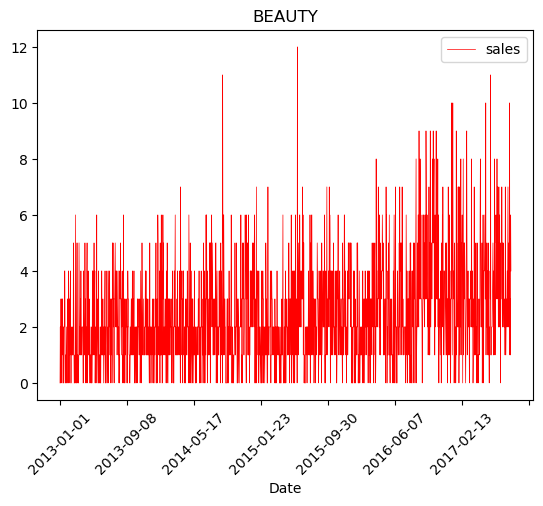

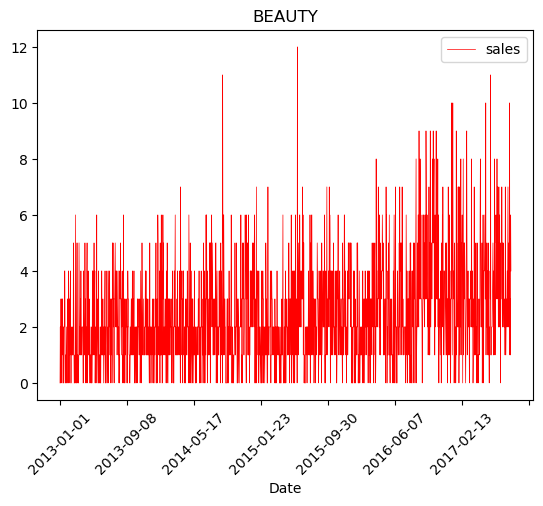

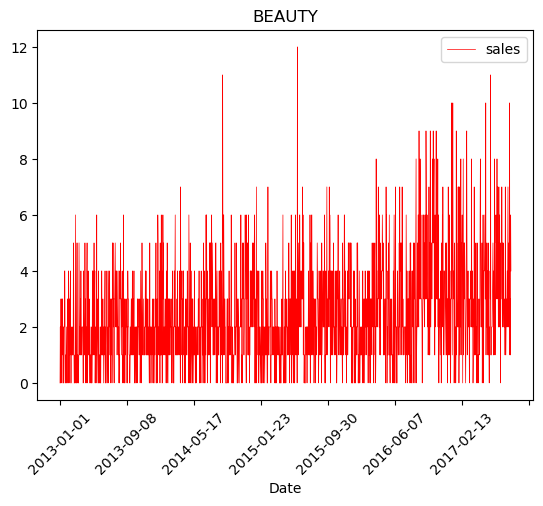

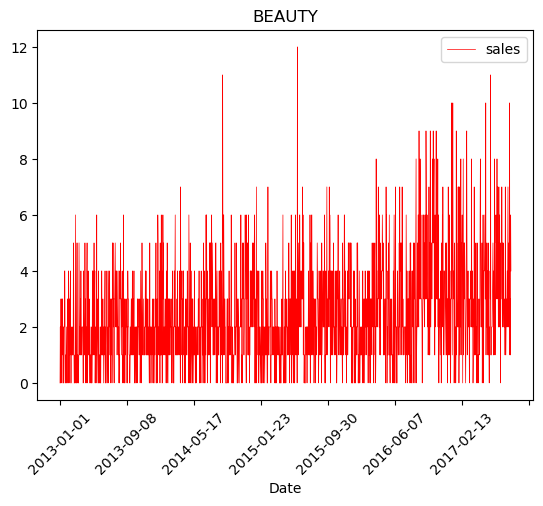

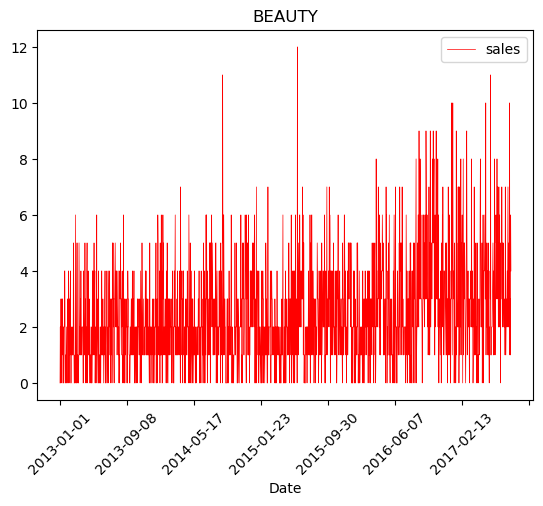

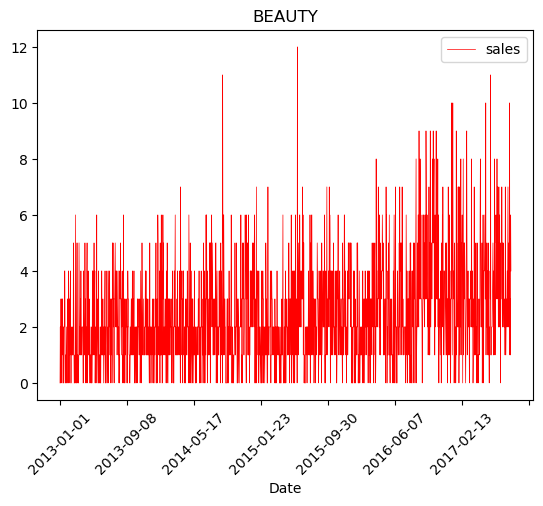

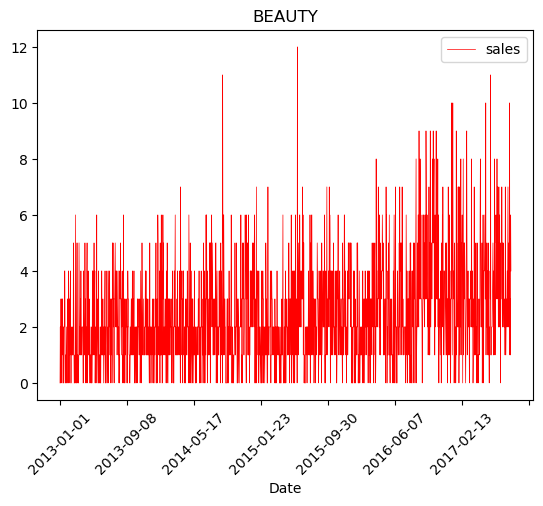

In [232]:
# plot sales for every family in a loop 
# plot sales for every family in a loop 
for family in store1['family'].unique()():
    family = store1['family'].unique((()))[2]
    # change color for red

    store1[store1['family']==family].plot(x='date',y='sales',title=family,linewidth=0.5, color='red')
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    # add title and labels
    plt.title(family)
    plt.xlabel('Date')

    plt.show()